# INGESTION DE DATOS TRANSACCIONALES

In [1]:
## CONFIGURACION DE AWS RDS

In [16]:
# Librerias necesarias
import boto3
import pandas as pd
import numpy as np
import psycopg2
import configparser
from faker import Faker
from sqlalchemy import create_engine
from sqlalchemy import text
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
warnings.filterwarnings('ignore')


In [3]:
# Documento privado de claves
config = configparser.ConfigParser()
config.read('config.cfg')

['config.cfg']

In [4]:
# Identificacion con AWS
aws_rds_conn = boto3.client('rds', aws_access_key_id=config.get('IAM','ACCESS_KEY'),
                             aws_secret_access_key=config.get('IAM','SECRET_ACCESS_KEY'),
                             region_name='us-east-1')

In [5]:
#Verificacion de instancias creadas anteriormente.

rds_instances_ids = []
aws_response = aws_rds_conn.describe_db_instances() 

for response in aws_response['DBInstances']:
    rds_instances_ids.append(response['DBInstanceIdentifier'])

print(f"Instancias Disponibles : {rds_instances_ids}")

Instancias Disponibles : ['banco-transactional']


In [6]:
#creacion de la base de datos

try:
    response = aws_rds_conn.create_db_instance(
        DBInstanceIdentifier = config.get('TRANSACC','DB_INSTANCE_ID'),
        DBName = config.get('TRANSACC','DB_NAME'),
        DBInstanceClass = 'db.t3.micro',
        Engine = 'postgres',
        MasterUsername = config.get('TRANSACC','DB_USER'),
        MasterUserPassword = config.get('TRANSACC','DB_PASSWORD'),
        Port = int(config.get('TRANSACC','DB_PORT')),
        PubliclyAccessible = True,
        VpcSecurityGroupIds = [config.get('VPC','SECURITY_GROUP')],
        AllocatedStorage = 15
               )
    print(response)
except aws_rds_conn.exceptions.DBInstanceAlreadyExistsFault as ex:
    print('La instancia ya existe')
except Exeption as ex:
    print('ERROR', ex)

La instancia ya existe


### Obtencion del hostname de las instancias

In [7]:
# codigo para obtener el hostname

try: 
    instance = aws_rds_conn.describe_db_instances(DBInstanceIdentifier = config.get('TRANSACC','DB_INSTANCE_ID'))
    RDS_HOSTNAME = instance.get('DBInstances')[0].get('Endpoint').get('Address')
    print(RDS_HOSTNAME)
except Exception as ex:
    print('Error', ex)

banco-transactional.c1m44mee4c6c.us-east-1.rds.amazonaws.com


### Conexion de base de datos desde python

In [8]:
import sql_queries

In [10]:
#creacion de database de datos
try:
    db_pg_conn = psycopg2.connect(
                    dbname = config.get('TRANSACC','DB_NAME'),
                    user = config.get('TRANSACC','DB_USER'),
                    password = config.get('TRANSACC','DB_PASSWORD'),
                    host = RDS_HOSTNAME,
                    port = config.get('TRANSACC','DB_PORT')
    )
    cursor = db_pg_conn.cursor()
    cursor.execute(sql_queries.DDL_QUERY)
    db_pg_conn.commit()
    print('Base de datos creada exitosamente')

except Exception as ex:
    print('ERROR', ex)

Base de datos creada exitosamente


## Generacion de datos con Faker

In [11]:
# Carga de librerias nuevamente
from faker import Faker
import pandas as pd
from sqlalchemy import create_engine
from configparser import ConfigParser

In [12]:
# # Conectar a la base de datos PostgreSQL usando SQLAlchemy

driver = f"""postgresql://{config.get('TRANSACC', 'DB_USER')}:{config.get('TRANSACC', 'DB_PASSWORD')}@{RDS_HOSTNAME}:{config.get('TRANSACC', 'DB_PORT')}/{config.get('TRANSACC', 'DB_NAME')}"""
engine = create_engine(driver)
# insertData2SQL(data_tipo_transacciones, 'tipo_transacciones', driver)

In [13]:
#ingreso de data para 'CATEGORIA'
# Inicializar Faker
fake = Faker()

# Función para generar datos para la tabla 'categoria'
def generate_categoria_data(n):
    data = []
    for _ in range(n):
        data.append({
            "nombre": fake.word(),
            "descripcion": fake.text(max_nb_chars=255),
            "estado": fake.boolean()
        })
    return data

# Insertar datos a la base de datos
def insertData2SQL(data, table_name, engine):
    df_data = pd.DataFrame(data)
    try:
        response = df_data.to_sql(table_name, engine, index=False, if_exists='append')
        print(f"Se han insertado {len(df_data)} nuevos registros en la tabla {table_name}.")
    except Exception as ex:
        print(f"Error al insertar datos: {ex}")

# Generar 1000 registros de datos para 'categoria'
data_categoria = generate_categoria_data(1000)

# Crear motor SQLAlchemy
engine = create_engine(driver)

# Insertar datos generados en la tabla 'categoria'
insertData2SQL(data_categoria, 'categoria', driver)

Se han insertado 1000 nuevos registros en la tabla categoria.


In [14]:
# INGRESO DE DATA PARA ROL
# Inicializar Faker
fake = Faker()

# Función para generar datos para la tabla 'rol'
def generate_rol_data(n):
    data = []
    for _ in range(n):
        data.append({
            "nombre": fake.job()[:30],  # Genera nombres de roles basados en tipos de trabajos
            "descripcion": fake.text(max_nb_chars=255),  # Descripción falsa
            "estado": fake.boolean()  # Estado aleatorio
        })
    return data

# Insertar datos a la base de datos
def insertData2SQL(data, table_name, engine):
    df_data = pd.DataFrame(data)
    try:
        response = df_data.to_sql(table_name, engine, index=False, if_exists='append')
        print(f"Se han insertado {len(df_data)} nuevos registros en la tabla {table_name}.")
    except Exception as ex:
        print(f"Error al insertar datos: {ex}")

# Generar 1000 registros de datos para 'categoria'
data_rol = generate_rol_data(1000)

# Crear motor SQLAlchemy
engine = create_engine(driver)

# Insertar datos generados en la tabla 'categoria'
insertData2SQL(data_rol, 'rol', driver)

Se han insertado 1000 nuevos registros en la tabla rol.


In [15]:
#INGRESO DE DATA PARA USUARIO
# Inicializar Faker
fake = Faker()

# Crear el motor SQLAlchemy
engine = create_engine(driver)
Session = sessionmaker(bind=engine)
session = Session()

# Función para obtener los roles existentes
def get_existing_roles(session):
    results = session.execute(text("SELECT idrol FROM rol"))
    existing_roles = [row[0] for row in results]
    return existing_roles

# Obtener los roles existentes
existing_roles = get_existing_roles(session)

# Función para generar datos para la tabla 'usuario'
def generate_usuario_data(n, existing_roles):
    data = []
    for _ in range(n):
        data.append({
            "idrol": fake.random.choice(existing_roles),
            "nombre": fake.name()[:100],
            "tipo_documento": fake.random.choice(['DNI', 'PAS', 'RUC', 'CE'])[:20],
            "num_documento": fake.bothify(text='########')[:20],
            "direccion": fake.address()[:70],
            "telefono": fake.phone_number()[:20],
            "email": fake.email()[:50],
            "clave": fake.password(length=10, special_chars=True, digits=True, upper_case=True, lower_case=True)[:50],
            "estado": fake.boolean()
        })
    return data

# Función para insertar datos en la base de datos
def insertData2SQL(data, table_name, engine):
    df_data = pd.DataFrame(data)
    try:
        response = df_data.to_sql(table_name, engine, index=False, if_exists='append')
        print(f"Se han insertado {len(df_data)} nuevos registros en la tabla {table_name}.")
    except Exception as ex:
        print(f"Error al insertar datos: {ex}")

# Generar 1000 registros de datos para 'usuario'
data_usuario = generate_usuario_data(1000, existing_roles)

# Insertar datos generados en la tabla 'usuario'
insertData2SQL(data_usuario, 'usuario', driver)

# Cerrar la sesión
session.close()

NameError: name 'sessionmaker' is not defined

In [ ]:
# INGRESO DE DATA PARA PERSONA
# Inicializar Faker
fake = Faker()

# Función para generar datos para la tabla 'persona'
def generate_persona_data(n):
    data = []
    for _ in range(n):
        tipo_persona_choice = fake.random_element(elements=('Natural', 'Jurídica'))
        tipo_documento_choice = fake.random_element(elements=('DNI', 'PAS', 'RUC', 'CE'))
        data.append({
            "tipo_persona": tipo_persona_choice[:20],  # Asegurar max 20 caracteres
            "nombre": fake.name()[:100],  # Asegurar max 100 caracteres
            "tipo_documento": tipo_documento_choice[:20],  # Asegurar max 20 caracteres
            "num_documento": fake.bothify(text='?#######', letters='ABCDEFGHJKLMNPQRSTUVWXYZ')[:20],  # Asegurar max 20 caracteres
            "direccion": fake.street_address()[:70],  # Asegurar max 70 caracteres
            "telefono": fake.phone_number()[:20],  # Asegurar max 20 caracteres
            "email": fake.email()[:50]  # Asegurar max 50 caracteres
        })
    return data

# Insertar datos a la base de datos
def insertData2SQL(data, table_name, engine):
    df_data = pd.DataFrame(data)
    try:
        response = df_data.to_sql(table_name, engine, index=False, if_exists='append')
        print(f"Se han insertado {len(df_data)} nuevos registros en la tabla {table_name}.")
    except Exception as ex:
        print(f"Error al insertar datos: {ex}")

# Generar 1000 registros de datos para 'persona'
data_persona = generate_persona_data(1000)

# Crear motor SQLAlchemy
engine = create_engine(driver)

# Insertar datos generados en la tabla 'persona'
insertData2SQL(data_persona, 'persona', driver)

In [ ]:
#INGRESO DE DATA PARA VENTA

# Inicializar Faker
fake = Faker()

# Crear el motor SQLAlchemy
engine = create_engine(driver)  
Session = sessionmaker(bind=engine)
session = Session()

def get_existing_personas(session):
    results = session.execute(text("SELECT idpersona FROM persona"))
    existing_personas = [row[0] for row in results]  
    return existing_personas

def get_existing_usuarios(session):
    results = session.execute(text("SELECT idusuario FROM usuario"))
    existing_usuarios = [row[0] for row in results]  
    return existing_usuarios

# Obtener los IDs existentes
existing_personas = get_existing_personas(session)
existing_usuarios = get_existing_usuarios(session)

# Función para generar datos para la tabla 'venta'
def generate_venta_data(n, existing_personas, existing_usuarios):
    data = []
    for _ in range(n):
        data.append({
            "idcliente": fake.random.choice(existing_personas),
            "idusuario": fake.random.choice(existing_usuarios),
            "tipo_comprobante": fake.random_element(elements=('Factura', 'Boleta', 'Ticket'))[:20],
            "serie_comprobante": fake.bothify(text='??###')[:7],
            "num_comprobante": fake.bothify(text='#######')[:10],
            "fecha": datetime.now(),
            "impuesto": round(fake.random_number(digits=2) + fake.random.random(), 2),
            "total": round(fake.random_number(digits=5) + fake.random.random(), 2),
            "estado": fake.random_element(elements=('Activo', 'Cancelado', 'Pendiente'))[:20]
        })
    return data

# Función para insertar datos en la base de datos
def insertData2SQL(data, table_name, engine):
    df_data = pd.DataFrame(data)
    try:
        df_data.to_sql(table_name, engine, index=False, if_exists='append')
        print(f"Se han insertado {len(df_data)} nuevos registros en la tabla {table_name}.")
    except Exception as ex:
        print(f"Error al insertar datos: {ex}")

# Generar 1000 registros de datos para 'venta'
data_venta = generate_venta_data(1000, existing_personas, existing_usuarios)

# Insertar datos generados en la tabla 'venta'
insertData2SQL(data_venta, 'venta', driver)

# Cerrar la sesión
session.close()

In [ ]:
#INGRESO DE DATA PARA ARTICULO

# Inicializar Faker
fake = Faker()

# Crear el motor SQLAlchemy
engine = create_engine(driver)  
Session = sessionmaker(bind=engine)
session = Session()

# Función para obtener los ID de categorías existentes
def get_existing_categorias(session):
    results = session.execute(text("SELECT idcategoria FROM categoria"))
    existing_categorias = [row[0] for row in results]  # Corregido para usar el nombre correcto
    return existing_categorias

# Obtener los IDs existentes
existing_categorias = get_existing_categorias(session)

# Función para generar datos para la tabla 'articulo'
def generate_articulo_data(n, existing_categorias):
    data = []
    for _ in range(n):
        data.append({
            "idcategoria": fake.random.choice(existing_categorias),
            "codigo": fake.bothify(text='??#####')[:50],  # Código con un máximo de 50 caracteres
            "nombre": fake.company()[:100],  # Nombre con un máximo de 100 caracteres
            "precio_venta": round(fake.random_number(digits=5) + fake.random.random(), 2),
            "stock": fake.random_int(min=0, max=1000),
            "descripcion": fake.text(max_nb_chars=255),  # Descripción con un máximo de 255 caracteres
            "imagen": fake.file_name(category='image', extension='png')[:20],  # Imagen con un máximo de 20 caracteres
            "estado": fake.boolean()
        })
    return data


# Función para insertar datos en la base de datos
def insertData2SQL(data, table_name, engine):
    df_data = pd.DataFrame(data)
    try:
        df_data.to_sql(table_name, engine, index=False, if_exists='append')
        print(f"Se han insertado {len(df_data)} nuevos registros en la tabla {table_name}.")
    except Exception as ex:
        print(f"Error al insertar datos: {ex}")

# Generar 1000 registros de datos para 'articulo'
data_articulo = generate_articulo_data(1000, existing_categorias)

# Insertar datos generados en la tabla 'articulo'
insertData2SQL(data_articulo, 'articulo', driver)

# Cerrar la sesión
session.close()

In [ ]:
#INGRESO DE DATA PARA detalle de venta

# Inicializar Faker
fake = Faker()

# Crear el motor SQLAlchemy
engine = create_engine(driver)  
Session = sessionmaker(bind=engine)
session = Session()

def get_existing_ventas(session):
    results = session.execute(text("SELECT idventa FROM venta"))
    existing_ventas = [row[0] for row in results] 
    return existing_ventas

def get_existing_articulos(session):
    results = session.execute(text("SELECT idarticulo FROM articulo"))
    existing_articulos = [row[0] for row in results]  
    return existing_articulos

# Obtener los IDs existentes
existing_ventas = get_existing_personas(session)
existing_articulos = get_existing_usuarios(session)

# Función para generar datos para la tabla 'detalle de venta'
def generate_detalle_venta_data(n, existing_ventas, existing_articulos):
    data = []
    for _ in range(n):
        idventa = fake.random.choice(existing_ventas)
        idarticulo = fake.random.choice(existing_articulos)
        cantidad = fake.random_int(min=1, max=100)
        precio = round(fake.random_number(digits=7) + fake.random.random(), 2)  # NUMERIC(11, 2)
        descuento = round(fake.random_number(digits=4) * 0.01, 2)  # NUMERIC(11, 2), descuento realista

        data.append({
            "idventa": idventa,
            "idarticulo": idarticulo,
            "cantidad": cantidad,
            "precio": precio,
            "descuento": descuento
        })
    return data


# Función para insertar datos en la base de datos
def insertData2SQL(data, table_name, engine):
    df_data = pd.DataFrame(data)
    try:
        df_data.to_sql(table_name, engine, index=False, if_exists='append')
        print(f"Se han insertado {len(df_data)} nuevos registros en la tabla {table_name}.")
    except Exception as ex:
        print(f"Error al insertar datos: {ex}")

# Generar 1000 registros de datos para 'detalle venta'
data_detalle_venta = generate_detalle_venta_data(1000, existing_ventas, existing_articulos)

# Insertar datos generados en la tabla 'detalle venta'
insertData2SQL(data_detalle_venta, 'detalle_venta', driver)

# Cerrar la sesión
session.close()

In [ ]:
#INGRESO DE DATA PARA ingreso
# Inicializar Faker
fake = Faker()

# Crear el motor SQLAlchemy
engine = create_engine(driver)
Session = sessionmaker(bind=engine)
session = Session()

def get_existing_proveedores(session):
    results = session.execute(text("SELECT idpersona FROM persona"))
    existing_proveedores = [row[0] for row in results]
    return existing_proveedores

def get_existing_usuarios(session):
    results = session.execute(text("SELECT idusuario FROM usuario"))
    existing_usuarios = [row[0] for row in results]
    return existing_usuarios

# Obtener los IDs existentes
existing_proveedores = get_existing_proveedores(session)
existing_usuarios = get_existing_usuarios(session)

# Función para generar datos para la tabla 'ingreso'
def generate_ingreso_data(n, existing_proveedores, existing_usuarios):
    data = []
    for _ in range(n):
        data.append({
            "idproveedor": fake.random.choice(existing_proveedores),
            "idusuario": fake.random.choice(existing_usuarios),
            "tipo_comprobante": fake.random_element(elements=('Factura', 'Boleta', 'Nota de Crédito'))[:20],
            "serie_comprobante": fake.bothify(text='??###')[:7],
            "num_comprobante": fake.bothify(text='#######')[:10],
            "fecha": fake.date_time_this_year(before_now=True, after_now=False),
            "impuesto": round(fake.random_number(digits=2) + fake.random.random(), 2),
            "total": round(fake.random_number(digits=5) + fake.random.random(), 2),
            "estado": fake.random_element(elements=('Activo', 'Inactivo'))[:20]
        })
    return data


# Función para insertar datos en la base de datos
def insertData2SQL(data, table_name, engine):
    df_data = pd.DataFrame(data)
    try:
        df_data.to_sql(table_name, engine, index=False, if_exists='append')
        print(f"Se han insertado {len(df_data)} nuevos registros en la tabla {table_name}.")
    except Exception as ex:
        print(f"Error al insertar datos: {ex}")

# Generar 1000 registros de datos para 'ingreso'
data_ingreso = generate_ingreso_data(1000, existing_proveedores, existing_usuarios)

# Insertar datos generados en la tabla 'ingreso'
insertData2SQL(data_ingreso, 'ingreso', driver)

# Cerrar la sesión
session.close()

In [ ]:
#INGRESO DE DATA PARA detalle ingreso
# Inicializar Faker
fake = Faker()

# Crear el motor SQLAlchemy
engine = create_engine(driver)
Session = sessionmaker(bind=engine)
session = Session()

def get_existing_ingresos(session):
    results = session.execute(text("SELECT idingreso FROM ingreso"))
    existing_ingresos = [row[0] for row in results]
    return existing_ingresos

def get_existing_articulos(session):
    results = session.execute(text("SELECT idarticulo FROM articulo"))
    existing_articulos = [row[0] for row in results]
    return existing_articulos

# Obtener los IDs existentes
existing_ingresos = get_existing_ingresos(session)
existing_articulos = get_existing_articulos(session)

# Función para generar datos para la tabla 'detalle_ingreso'
def generate_detalle_ingreso_data(n, existing_ingresos, existing_articulos):
    data = []
    for _ in range(n):
        idingreso = fake.random.choice(existing_ingresos)
        idarticulo = fake.random.choice(existing_articulos)
        cantidad = fake.random_int(min=1, max=100)
        precio = round(fake.random_number(digits=7) + fake.random.random(), 2)  # NUMERIC(11, 2)

        data.append({
            "idingreso": idingreso,
            "idarticulo": idarticulo,
            "cantidad": cantidad,
            "precio": precio
        })
    return data


# Función para insertar datos en la base de datos
def insertData2SQL(data, table_name, engine):
    df_data = pd.DataFrame(data)
    try:
        df_data.to_sql(table_name, engine, index=False, if_exists='append')
        print(f"Se han insertado {len(df_data)} nuevos registros en la tabla {table_name}.")
    except Exception as ex:
        print(f"Error al insertar datos: {ex}")

# Generar 1000 registros de datos para 'detalle ingreso'
data_detalle_ingreso = generate_detalle_ingreso_data(1000, existing_ingresos, existing_articulos)

# Insertar datos generados en la tabla 'detalle_ingreso'
insertData2SQL(data_detalle_ingreso, 'detalle_ingreso', driver)

# Cerrar la sesión
session.close()

In [ ]:
## Analisis de datos

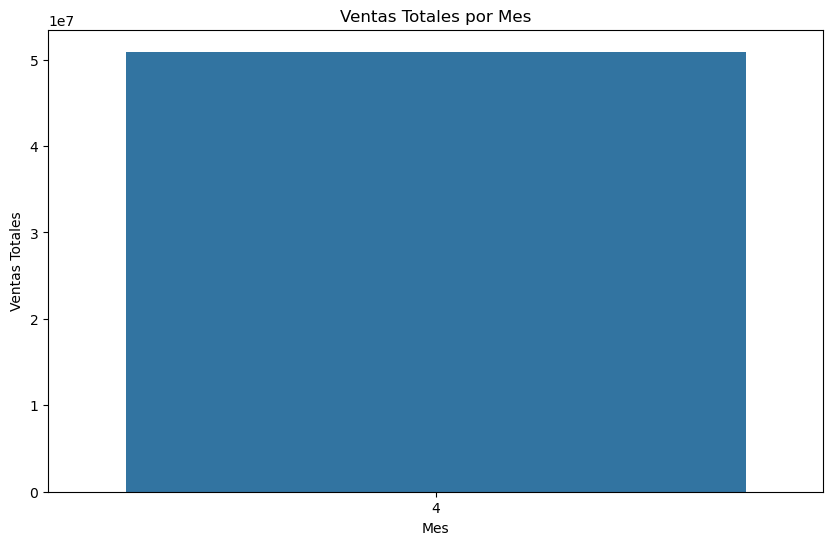

In [20]:
driver = f"""postgresql://{config.get('TRANSACC', 'DB_USER')}:{config.get('TRANSACC', 'DB_PASSWORD')}@{RDS_HOSTNAME}:{config.get('TRANSACC', 'DB_PORT')}/{config.get('TRANSACC', 'DB_NAME')}"""
engine = create_engine(driver)

# Cargar los datos de las ventas
query_ventas = "SELECT * FROM venta"
df_venta = pd.read_sql(query_ventas, engine)

# Asegúrate de que la columna 'fecha' se convierte en tipo datetime si no lo es
df_venta['fecha'] = pd.to_datetime(df_venta['fecha'])

# Extraer el mes de la columna de fecha
df_venta['mes'] = df_venta['fecha'].dt.month

# Asegúrate de que la columna 'total' es numérica (revisa tus columnas)
if 'total' in df_venta.columns:
    # Agrupar por mes y sumar las ventas totales
    ventas_por_mes = df_venta.groupby('mes')['total'].sum()

    # Gráfico de las ventas por mes
    plt.figure(figsize=(10, 6))
    sns.barplot(x=ventas_por_mes.index, y=ventas_por_mes.values)
    plt.title('Ventas Totales por Mes')
    plt.xlabel('Mes')
    plt.ylabel('Ventas Totales')
    plt.show()
else:
    print("La columna 'total' no se encuentra en el DataFrame.")